# Headmaster

**17.12.2023**

*How to became pacino*

In [118]:
from pathlib import Path
import torch
from torch import nn
from lightweight_gan import LightweightGAN
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision.transforms import v2




torch.cuda.is_available()

True

**people seen faces in movies and in books**

![PaczPaczino](img/pacino_book.jpg)

## Big head

*He imagined that he might shape his own face to look like that of the actor Al Pacino, whom he admired. AI Pacino was in his mind all the time*

![AI-pacino](img/ai-pacino.jpg)

[Fig 1. -- sample images generated by [lighweight gan](https://github.com/lucidrains/lightweight-gan) - thrid-party implementation of [FastGAN](https://openreview.net/forum?id=1Fqg133qRaI) ]

*He has created a model that would mend the forehead of imaginary pacinos*

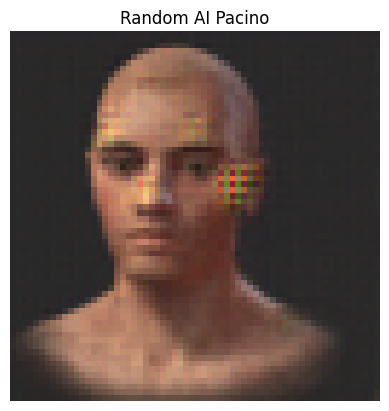

In [100]:
LATENT_DIM = 256
IMG_SIZE = 64

def import_generator(model_filepath: Path) -> torch.nn.Module:
    model = torch.load(model_filepath)
    
    gan = LightweightGAN(latent_dim=LATENT_DIM, image_size=IMG_SIZE, attn_res_layers=[32], freq_chan_attn=False, blur=nn.Identity)
    gan.load_state_dict(model["GAN"], strict=False)
    gan.eval()

    return gan.G

def prep_tensor_to_show(tensor):
    return tensor.permute(1, 2, 0).detach().to('cpu').numpy()

def show_tensor_picture(tensor, title=""):
    im_arr = prep_tensor_to_show(tensor)
    plt.title(title)
    plt.axis("off")
    plt.imshow(im_arr)


generator = import_generator(Path("models/model_al_pacino_forehead.pt"))

random_latent_vectors = torch.randn( (1, LATENT_DIM) ).cuda(0)
generated_images = generator(random_latent_vectors)
show_tensor_picture(generated_images[0], title="Random AI Pacino")

- 

In [101]:

def generate_intermediate_vectors(a_vec, b_vec, n):
    step_vec = (b_vec - a_vec - 1)/n
    return [ a_vec + i * step_vec for i in range(n+2)]

generate_intermediate_vectors(np.array([2,3,4]), np.array([5,6,7]), 2)

[array([2., 3., 4.]),
 array([3., 4., 5.]),
 array([4., 5., 6.]),
 array([5., 6., 7.])]

The `generate_intermediate_vectors` is inclusive, but does not count the border vectors.

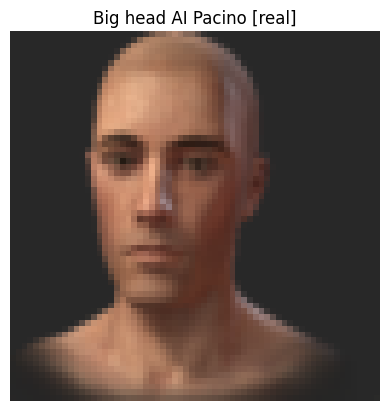

In [102]:
# 13
AI_PACINO_SMALL_HEAD_PATH = "img/smallest-head.png"
AI_PACINO_BIG_HEAD_PATH = "img/biggest-head.png"

def prep_image(filename)-> torch.tensor:
    image = Image.open(filename).convert("RGB")
    image_min_size = min(image.size)
    transforms = v2.Compose([
        v2.ToImage(),
        v2.CenterCrop(image_min_size),
        v2.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
        v2.ToDtype(torch.float32, scale=True)
    ])
    return transforms(image).cuda(0)


big_pacino_real = prep_image(AI_PACINO_BIG_HEAD_PATH)
show_tensor_picture(big_pacino_real, "Big head AI Pacino [real]")


In [103]:
def find_z(exemplary_photo_filename, generator, iterations=100, lr=5, checkpoint_step=10):
    z = torch.randn( (1, LATENT_DIM), requires_grad=True, device="cuda")
    y_target = prep_image(exemplary_photo_filename)

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD([z], lr=lr, momentum=0.9)

    checkpoints = []
    for i in range(iterations):
        y_pred = generator(z)[0]
        loss = criterion(y_target, y_pred)
        print(f"{i} {loss.item()}")

        if i % checkpoint_step == 0:
            checkpoints.append((i, y_pred.detach().permute((1,2,0)).cpu().numpy()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return z, checkpoints


big_head_z, big_head_checkpoints = find_z(AI_PACINO_BIG_HEAD_PATH, generator)



0 0.01330767571926117
1 0.012836894020438194
2 0.011983073316514492
3 0.010891592130064964
4 0.009416419081389904
5 0.007518821861594915
6 0.004976851865649223
7 0.003326304955407977
8 0.002581355394795537
9 0.002114387694746256
10 0.0017776265740394592
11 0.0015250103315338492
12 0.001351807964965701
13 0.0012295180931687355
14 0.001141189131885767
15 0.0010760899167507887
16 0.0010266428580507636
17 0.0009853264782577753
18 0.0009548895759508014
19 0.0009326739236712456
20 0.0009111628751270473
21 0.0008948331233114004
22 0.0008810238796286285
23 0.0008694713469594717
24 0.0008586375042796135
25 0.0008519936818629503
26 0.0008435847121290863
27 0.0008365903049707413
28 0.0008304313523694873
29 0.0008267890079878271
30 0.0008211898384615779
31 0.0008179103024303913
32 0.0008137704571709037
33 0.0008115022792480886
34 0.0008072330383583903
35 0.000804756477009505
36 0.0008030746830627322
37 0.0008012013277038932
38 0.0007988379802554846
39 0.0007978704525157809
40 0.0007963778334669769

Big learning rate (more than one) has converged far quicker and the *lack of precision* was not that much of a problem. Even values like 100 have been useful and made the algorithm converge within few iterations.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


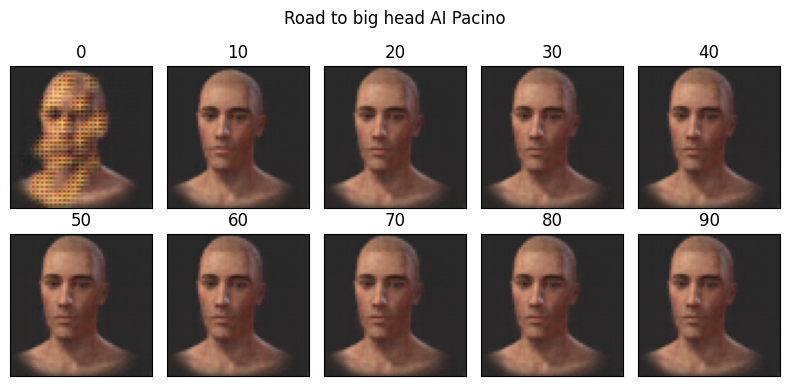

In [104]:
def plot_images(images, labels, nrows, ncols, step=1, title="", figsize=[8, 4]):
    """Plot nrows x ncols images from images and set labels as titles."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        idx = i * step
        if images[i].shape[-1] == 1:
            ax.imshow(images[i].reshape(images[idx].shape[0], images[idx].shape[1]))
        else:
            ax.imshow(images[idx])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(labels[idx])
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

checkpoint_names, checkpoint_images = [i for i,_ in big_head_checkpoints], [j for _,j in big_head_checkpoints]
plot_images(checkpoint_images, checkpoint_names, 2, 5, title="Road to big head AI Pacino")

*Lubię tego zerowego* - Agata

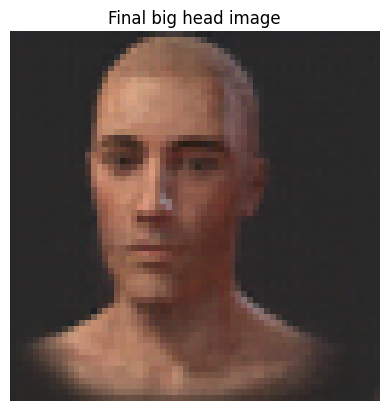

In [105]:
fake_big_head_pacino = generator(big_head_z)[0]
show_tensor_picture(fake_big_head_pacino, "Final big head image")

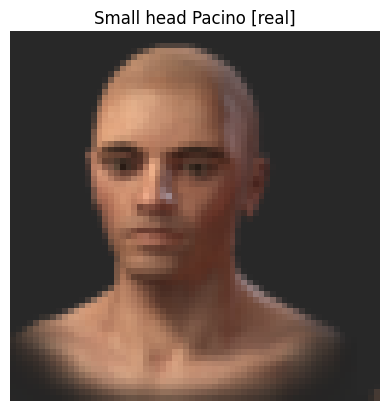

In [106]:
real_small_head_pacino = prep_image(SMALL_HEAD_PATH)
show_tensor_picture(real_small_head_pacino, title="Small head Pacino [real]")


In [107]:
small_head_z, small_head_checkpoints = find_z(SMALL_HEAD_PATH, generator)

0 0.005606980063021183
1 0.005599051248282194
2 0.005589313805103302
3 0.00557586457580328
4 0.005554640665650368
5 0.0055305128917098045
6 0.005503849592059851
7 0.00547190522775054
8 0.005434982478618622
9 0.005396567285060883
10 0.00535120815038681
11 0.005300627090036869
12 0.005246683955192566
13 0.005186280235648155
14 0.005118987523019314
15 0.00504647009074688
16 0.0049661798402667046
17 0.004878637380897999
18 0.0047781020402908325
19 0.004661767743527889
20 0.004532979801297188
21 0.0044029937125742435
22 0.004306237678974867
23 0.004215207416564226
24 0.0040764096193015575
25 0.003966729622334242
26 0.003894598688930273
27 0.0037950638215988874
28 0.00363600323908031
29 0.003433596808463335
30 0.0032126414589583874
31 0.0029698405414819717
32 0.0027169431559741497
33 0.0024560722522437572
34 0.002190834376960993
35 0.00193018838763237
36 0.0016823293408378959
37 0.001415367005392909
38 0.0011696014553308487
39 0.0009780098916962743
40 0.0007957343477755785
41 0.0006636376492

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


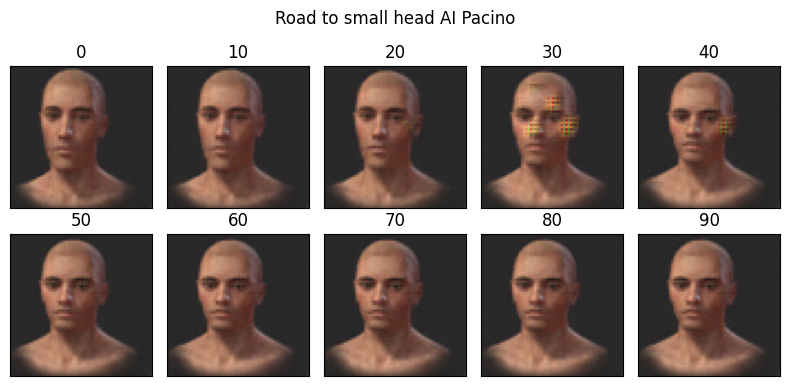

In [108]:
checkpoint_names, checkpoint_images = [i for i,_ in small_head_checkpoints], [j for _,j in small_head_checkpoints]
plot_images(checkpoint_images, checkpoint_names, 2, 5, title="Road to small head AI Pacino")

*Przy 60 zauważył, że ma krzywe brwi*

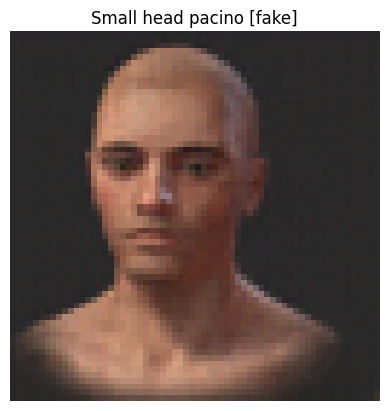

In [109]:
small_head_fake = generator(small_head_z)[0]
show_tensor_picture(small_head_fake, "Small head pacino [fake]")

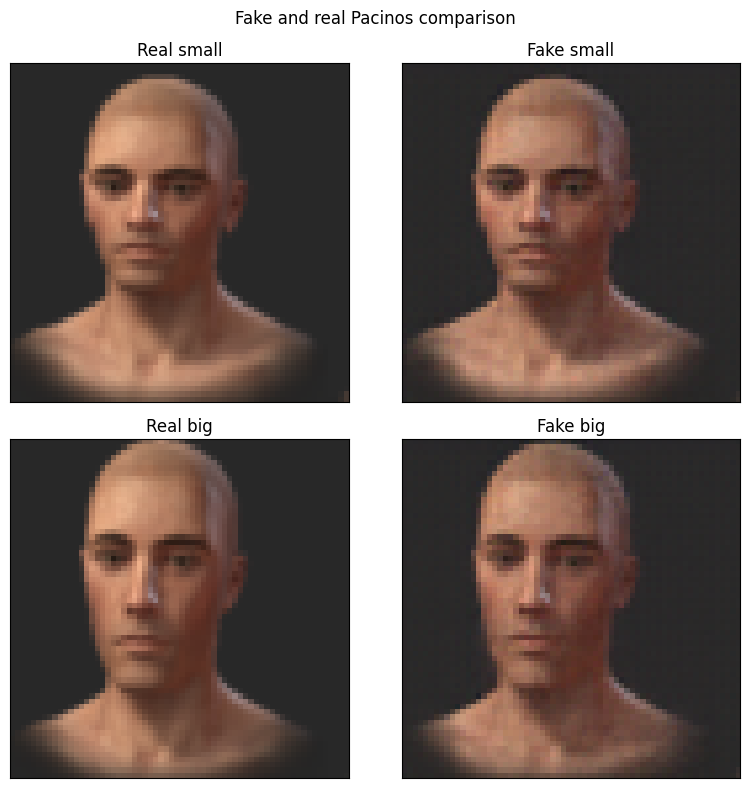

In [115]:
labels = ["Real small", "Fake small", "Real big", "Fake big"]
images = [prep_tensor_to_show(ai_pac) for ai_pac in [real_small_head_pacino, small_head_fake, big_pacino_real, fake_big_head_pacino]]

plot_images(images, labels, 2, 2, title="Fake and real Pacinos comparison", figsize=[8,8])

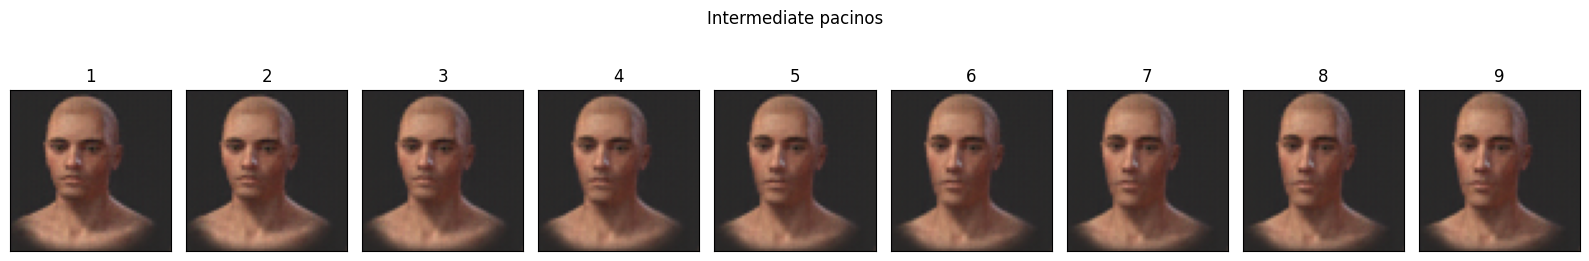

In [119]:
z_big, z_small, n = big_head_z, small_head_z, 9

intermediate_vectors = generate_intermediate_vectors(z_small, z_big, n)
images = [prep_tensor_to_show(generator(z)[0]) for z in intermediate_vectors]
labels = list(range(1, n+1))
plot_images(images, labels, ncols=9, nrows=1, title="Intermediate pacinos", figsize=[16,3])
